In [1]:
import sys 
sys.path.append("../")
import pandas as pd

#import backtester as bt
import backtester as bt

from abc import ABC, abstractmethod
import QuantLib as ql 
from datetime import date, datetime 
import matplotlib.pyplot as plt
import numpy as np

# BuyHold

In [16]:
# Esempio di utilizzo dell'indicatore nella strategia
class SMAStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance):
        super().__init__(universe, start_date, end_date, starting_balance)
        self.window = 10
        self.price_tickers = ['ISP_IM_Equity']
        self.position_open = False
        self.moving_average = MovingAverage()  # Assegna un'implementazione concreta

    def on_data(self):
        mkt = self.history[self.ref_date]
        isp_prices = bt.prices_to_df(self.history)['ISP_IM_Equity']

        if len(isp_prices) < self.window:
            return  # Non abbiamo abbastanza dati
        
        sma_isp = self.moving_average.compute("sma", isp_prices, self.window) # [-1]  Ultimo valore SMA
        close_isp = mkt['equity']['ISP_IM_Equity']['close']

        if not self.position_open and close_isp > sma_isp[-1]:
            position = bt.EquityPosition(symbol='ISP_IM_Equity', quantity=1, market_data=mkt, position_type=bt.PositionType.LONG)
            self.portfolio.add_position(position)
            self.position_open = True
        elif self.position_open and close_isp < sma_isp[-1]:
            eq_position = self.portfolio.get_positions('ISP_IM_Equity', bt.AssetType.EQUITY)[0]
            self.close_trade(eq_position, mkt)
            self.position_open = False

class BenchmarkStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance):
        super().__init__(universe, start_date, end_date, starting_balance)
        self.position_open = False   
        self.price_tickers = ['ISP_IM_Equity']


    def on_data(self):
        mkt = self.history[self.ref_date]

        if not self.position_open:
            position = bt.EquityPosition(symbol='ISP_IM_Equity', quantity=1, market_data=mkt, position_type=bt.PositionType.LONG)
            self.portfolio.add_position(position)
            self.position_open = True

# Definizione di un indicatore di esempio (SMA)
class MovingAverage(bt.Indicator):
    def __init__(self):
        super().__init__()
        self.register("sma")(self.simple_moving_average)

    def simple_moving_average(self, prices, window):
        """ Calcola la media mobile semplice (SMA) """
        return np.convolve(prices, np.ones(window) / window, mode='valid')
    
    def warmup(self, prices, window):
        """ Ensure there is enough historical data for the indicator """
        if len(prices) < window:
            return False  # Not enough data
        return True

In [17]:
universe = ['ISP_IM_Equity']
start_date = '2023-01-01'
end_date ='2024-12-31'
starting_balance=1000

backtester = SMAStrategy(universe, start_date, end_date, starting_balance)
backtester.backtest()

benchmark = BenchmarkStrategy(universe, start_date, end_date, starting_balance)
benchmark.backtest()

res = bt.ResultAnalyzer(backtester.positions_summary, backtester.period_pnl)
res_benchmark = bt.ResultAnalyzer(benchmark.positions_summary, benchmark.period_pnl)

In [18]:
backtester.positions_summary

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2023-01-13,2023-01-13,72620,ISP_IM_Equity,equity,1,1,2.2880,True,2.288,0.000,0.0000,0.0000
0,2023-01-16,2023-01-13,72620,ISP_IM_Equity,equity,1,1,2.2880,True,2.285,-0.003,0.0000,-0.0030
0,2023-01-17,2023-01-13,72620,ISP_IM_Equity,equity,1,1,2.2880,True,2.261,-0.027,0.0000,-0.0270
0,2023-01-18,2023-01-13,72620,ISP_IM_Equity,equity,1,0,2.2880,False,2.250,0.000,-0.0380,-0.0380
0,2023-01-19,2023-01-13,72620,ISP_IM_Equity,equity,1,0,2.2880,False,2.223,0.000,-0.0380,-0.0380
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,2024-12-30,2024-09-09,78704,ISP_IM_Equity,equity,1,0,3.7265,False,3.863,0.000,0.1365,0.1365
32,2024-12-30,2024-09-12,92616,ISP_IM_Equity,equity,1,0,3.7340,False,3.863,0.000,0.1290,0.1290
33,2024-12-30,2024-10-07,66462,ISP_IM_Equity,equity,1,0,3.8030,False,3.863,0.000,0.0600,0.0600
34,2024-12-30,2024-10-29,83926,ISP_IM_Equity,equity,1,0,3.9730,False,3.863,0.000,-0.1100,-0.1100


In [19]:
res.get_trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2023-01-13,2023-01-13,72620,ISP_IM_Equity,equity,1,1,2.2880,True,2.2880,0.0,0.0000,0.0000
1,2023-01-18,2023-01-13,72620,ISP_IM_Equity,equity,1,0,2.2880,False,2.2500,0.0,-0.0380,-0.0380
2,2023-01-24,2023-01-24,44326,ISP_IM_Equity,equity,1,1,2.2855,True,2.2855,0.0,0.0000,0.0000
3,2024-12-30,2023-01-24,44326,ISP_IM_Equity,equity,1,0,2.2855,False,3.8630,0.0,1.5775,1.5775
4,2023-02-27,2023-02-27,85743,ISP_IM_Equity,equity,1,1,2.5330,True,2.5330,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2024-12-30,2024-10-07,66462,ISP_IM_Equity,equity,1,0,3.8030,False,3.8630,0.0,0.0600,0.0600
68,2024-10-29,2024-10-29,83926,ISP_IM_Equity,equity,1,1,3.9730,True,3.9730,0.0,0.0000,0.0000
69,2024-12-30,2024-10-29,83926,ISP_IM_Equity,equity,1,0,3.9730,False,3.8630,0.0,-0.1100,-0.1100
70,2024-12-03,2024-12-03,49956,ISP_IM_Equity,equity,1,1,3.6815,True,3.6815,0.0,0.0000,0.0000


In [13]:
trade_log = res.get_trade_log()

In [14]:
trade_log

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2023-01-13,2023-01-13,49888,ISP_IM_Equity,equity,1,1,2.2880,True,2.2880,0.0,0.0000,0.0000
1,2023-01-18,2023-01-13,49888,ISP_IM_Equity,equity,1,0,2.2880,False,2.2500,0.0,-0.0380,-0.0380
2,2023-01-24,2023-01-24,37356,ISP_IM_Equity,equity,1,1,2.2855,True,2.2855,0.0,0.0000,0.0000
3,2024-12-30,2023-01-24,37356,ISP_IM_Equity,equity,1,0,2.2855,False,3.8630,0.0,1.5775,1.5775
4,2023-02-27,2023-02-27,78351,ISP_IM_Equity,equity,1,1,2.5330,True,2.5330,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2024-12-30,2024-10-07,19461,ISP_IM_Equity,equity,1,0,3.8030,False,3.8630,0.0,0.0600,0.0600
68,2024-10-29,2024-10-29,73249,ISP_IM_Equity,equity,1,1,3.9730,True,3.9730,0.0,0.0000,0.0000
69,2024-12-30,2024-10-29,73249,ISP_IM_Equity,equity,1,0,3.9730,False,3.8630,0.0,-0.1100,-0.1100
70,2024-12-03,2024-12-03,18977,ISP_IM_Equity,equity,1,1,3.6815,True,3.6815,0.0,0.0000,0.0000


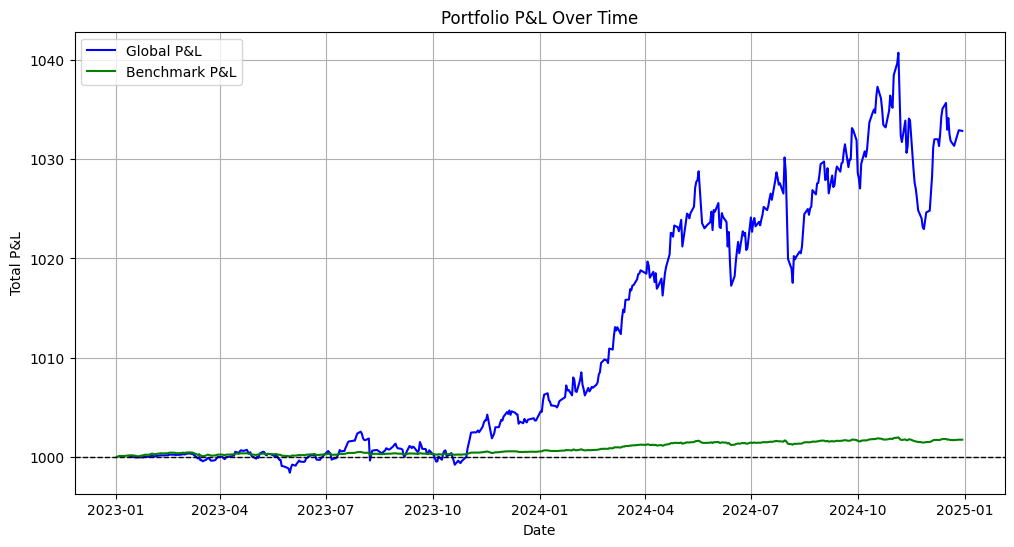

In [15]:
# res.get_trade_log()
res.plot_pnl(benchmark=res_benchmark)